In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.io.json import json_normalize
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from scipy.stats import skew, kurtosis, entropy, iqr, median_abs_deviation
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
def open_datos(url):
    with open(url, 'r') as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)
    return df


def find_signals(time_series):
    start_index = None
    max_abs_val = None
    signals = []
    
    for i, value in enumerate(time_series):
        if start_index is None and value <= -0.06:
            start_index = i
            max_abs_val = value
        elif start_index is not None:
            if value < max_abs_val:
                max_abs_val = value
            
            if value >= 0.03:
                signals.append((start_index, i, max_abs_val))
                start_index = None
                max_abs_val = None
    
    df = pd.DataFrame(signals, columns=['Start index', 'End index', 'Maximum Abs Value'])
    df["Duracion_Trade"]=df["End index"]-df["Start index"]
    return df

In [6]:
data=pd.read_csv("/Users/rogarciag/Desktop/AI_&_TRADING/ALGORITHMIC_TRADING/PRINCIPAL/NASINI/TRABAJOS_GENERAL/PROYECTO_TRADING/BASES_DE_DATOS/DATOS_CSV/AL30_COMPLETE_TASAS.csv")

In [7]:
time_series = pd.DataFrame(columns=['date','spread'])
# modifiique los nombres así era más claro

#APLICAR EXPONENTE HURST
data["SPREAD_COLOCAR_PLAZO_CERCANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)
data["SPREAD_COLOCAR_PLAZO_LEJANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data["SPREAD_TOMAR_PLAZO_CERCANO"] =data["TOMAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100) 
data["SPREAD_TOMAR_PLAZO_LEJANO"] = data["TOMAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data_general=data[["caucion_a_un_dia_ultimo_trade_tasa","SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

threshold_arbitrage=0

for index, row in data_general.iterrows():
    #Elegimos el mejor spread para colocar y tomar
    if  row["SPREAD_COLOCAR_PLAZO_CERCANO"] > row["SPREAD_COLOCAR_PLAZO_LEJANO"]:
         spread_colocar = row["SPREAD_COLOCAR_PLAZO_CERCANO"]
    else:
        spread_colocar = row["SPREAD_COLOCAR_PLAZO_LEJANO"]

    if row["SPREAD_TOMAR_PLAZO_CERCANO"] < row["SPREAD_TOMAR_PLAZO_LEJANO"]:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_CERCANO"]

    else:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_LEJANO"]

    # CASO NO PASA NADA
    if row["SPREAD_COLOCAR_PLAZO_CERCANO"] < threshold_arbitrage and row["SPREAD_COLOCAR_PLAZO_LEJANO"] < threshold_arbitrage  and row["SPREAD_TOMAR_PLAZO_CERCANO"] > threshold_arbitrage and row["SPREAD_TOMAR_PLAZO_LEJANO"] > threshold_arbitrage:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)
        
    elif spread_colocar > 0 and spread_tomar < 0:

        if spread_colocar > -spread_tomar:
            
            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)
        
        else:

            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)

    elif spread_colocar > 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)

    elif spread_tomar < 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)
    else:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)

In [5]:
x_DATA=time_series["spread"]
y_DATA=data_general=data[["SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

In [6]:
import pandas as pd

data=y_DATA
window = 60
dev_1=0.5
dev_2=1.0
dev_3=1.5



# Calculate the rolling mean for each column
data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=window).mean()
data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=window).mean()
data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=window).mean()
data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=window).mean()

data["SCORE"] = 0

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] < data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"], "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] < data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"], "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] < data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"]+ data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window).std() * dev_1, "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] < data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] + data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window).std() * dev_1, "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] < data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"]+ data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window).std() * dev_2, "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] < data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] + data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window).std() * dev_2, "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] < data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"]+ data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window).std() * dev_3, "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] < data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] + data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window).std() * dev_3, "SCORE"] += 1



data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"], "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"], "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window).std() * dev_1, "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"]  - data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window).std() * dev_1, "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window).std() * dev_2, "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window).std() * dev_2, "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window).std() * dev_3, "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window).std() * dev_3, "SCORE"] += 1

data.dropna(inplace=True)


In [7]:
final_df=pd.DataFrame()
final_df["Total_Spread"]=x_DATA
final_df["Total_Score_Parametro_1_negativo"]=data["SCORE"]

time_series = final_df["Total_Spread"]
result = find_signals(time_series)

df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted.dropna(inplace=True)

result_sorted

,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
2,240,1549,-3.311920,1309,11.0
8,2615,3503,-3.006852,888,12.0
6,1571,2506,-1.358197,935,14.0
33,5326,5587,-1.087408,261,10.0
4,1554,1563,-0.871009,9,11.0
32,4952,5324,-0.631199,372,10.0
5,1565,1570,-0.399987,5,13.0
10,3528,3655,-0.377281,127,14.0
7,2507,2608,-0.376510,101,10.0
18,3719,4444,-0.361816,725,13.0


# COMPARACION REGRESIONES LINEALES PARA MEDIAS 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from math import sqrt
import sklearn.metrics as metrics
import sklearn.metrics as sm
from sklearn.model_selection import GridSearchCV

In [9]:
result_filter=result_sorted[result_sorted["Duracion_Trade"]<50]
result_filter

,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
4,1554,1563,-0.871009,9,11.0
5,1565,1570,-0.399987,5,13.0
9,3507,3527,-0.357448,20,9.0
14,3683,3692,-0.241893,9,10.0
12,3669,3671,-0.212930,2,8.0
3,1551,1552,-0.211301,1,10.0
13,3672,3681,-0.199302,9,11.0
11,3658,3667,-0.196181,9,12.0
30,4934,4944,-0.167277,10,11.0
21,4765,4777,-0.152074,12,10.0


# COMPARACION 1 

<Axes: >

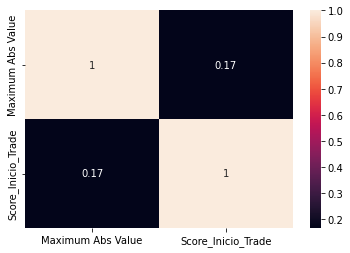

In [10]:
sns.heatmap(result_filter[["Maximum Abs Value","Score_Inicio_Trade"]].corr(),annot=True)

In [16]:
x=result_filter[['Maximum Abs Value']]
y=result_filter['Score_Inicio_Trade']

sc=StandardScaler().fit(x)
x_sc=sc.transform(x)

lm=LinearRegression()
lm.fit(x_sc, y)
predictions=lm.predict(x_sc)

print("Mean absolute error =", round(sm.mean_absolute_error(y, predictions), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, predictions), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y, predictions), 2))

Mean absolute error = 1.08
Mean squared error = 1.7
Median absolute error = 0.97
Explain variance score = 0.03
R2 score = 0.03


# COMPARACION 2 

In [6]:
data=y_DATA
window = 60
dev_1=0.5
dev_2=1.0
dev_3=1.5



# Calculate the rolling mean for each column
data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=window).mean()
data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=window).mean()
data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=window).mean()
data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=window).mean()

data["SCORE"] = 0

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"], "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"], "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"]+ data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window).std() * dev_1, "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] + data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window).std() * dev_1, "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"]+ data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window).std() * dev_2, "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] + data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window).std() * dev_2, "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MEAN"]+ data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window).std() * dev_3, "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MEAN"] + data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window).std() * dev_3, "SCORE"] += 1



data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] < data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"], "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] < data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"], "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] < data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window).std() * dev_1, "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] < data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"]  - data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window).std() * dev_1, "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] < data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window).std() * dev_2, "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] < data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window).std() * dev_2, "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO"] < data["SPREAD_TOMAR_PLAZO_CERCANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window).std() * dev_3, "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO"] < data["SPREAD_TOMAR_PLAZO_LEJANO_MEAN"] - data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window).std() * dev_3, "SCORE"] += 1

data.dropna(inplace=True)


final_df=pd.DataFrame()
final_df["Total_Spread"]=x_DATA
final_df["Total_Score_Parametro_1_negativo"]=data["SCORE"]

time_series = final_df["Total_Spread"]
result = find_signals(time_series)

df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted.dropna(inplace=True)

result_sorted

import pandas as pd

In [7]:
result_filter=result_sorted[result_sorted["Duracion_Trade"]<50]
result_filter

,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
4,1554,1563,-0.871009,9,5.0
5,1565,1570,-0.399987,5,3.0
9,3507,3527,-0.357448,20,7.0
14,3683,3692,-0.241893,9,6.0
12,3669,3671,-0.212930,2,8.0
3,1551,1552,-0.211301,1,6.0
13,3672,3681,-0.199302,9,5.0
11,3658,3667,-0.196181,9,4.0
30,4934,4944,-0.167277,10,5.0
21,4765,4777,-0.152074,12,6.0


<Axes: >

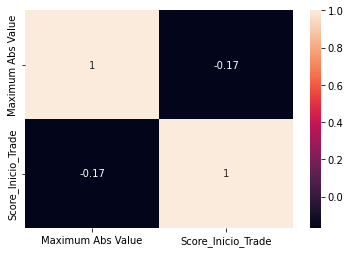

In [8]:
sns.heatmap(result_filter[["Maximum Abs Value","Score_Inicio_Trade"]].corr(),annot=True)

In [11]:
x=result_filter[['Maximum Abs Value']]
y=result_filter['Score_Inicio_Trade']

sc=StandardScaler().fit(x)
x_sc=sc.transform(x)

lm=LinearRegression()
lm.fit(x_sc, y)
predictions=lm.predict(x_sc)

print("Mean absolute error =", round(sm.mean_absolute_error(y, predictions), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, predictions), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y, predictions), 2))

Mean absolute error = 1.08
Mean squared error = 1.7
Median absolute error = 0.97
Explain variance score = 0.03
R2 score = 0.03


# VISUALIZACION DE MEDIAS

In [12]:
import yfinance as yf
data=yf.download("AAPL","2022-01-01","2023-01-01")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,180.683884,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,178.390701,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,173.645523,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,170.746811,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,170.915588,86709100
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.658981,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.831772,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.847855,85438400


In [13]:
SMA = 21
dev_1 = 0.5
dev_2 = 1
dev_3=1.5

In [141]:
data["SMA"] = data["Close"].rolling(SMA).mean()

In [142]:
data["Lower_1"] = data["SMA"] - data["Close"].rolling(SMA).std() * dev_1 # Lower Band -2 Std Dev
data["Lower_2"] = data["SMA"] - data["Close"].rolling(SMA).std() * dev_2 # Lower Band -2 Std Dev
data["Lower_3"] = data["SMA"] - data["Close"].rolling(SMA).std() * dev_3 # Lower Band -2 Std Dev

In [143]:
data["Upper_1"] = data["SMA"] + data["Close"].rolling(SMA).std() * dev_1 # Lower Band -2 Std Dev
data["Upper_2"] = data["SMA"] + data["Close"].rolling(SMA).std() * dev_2 # Lower Band -2 Std Dev
data["Upper_3"] = data["SMA"] + data["Close"].rolling(SMA).std() * dev_3 # Lower Band -2 Std Dev

<Axes: xlabel='Date'>

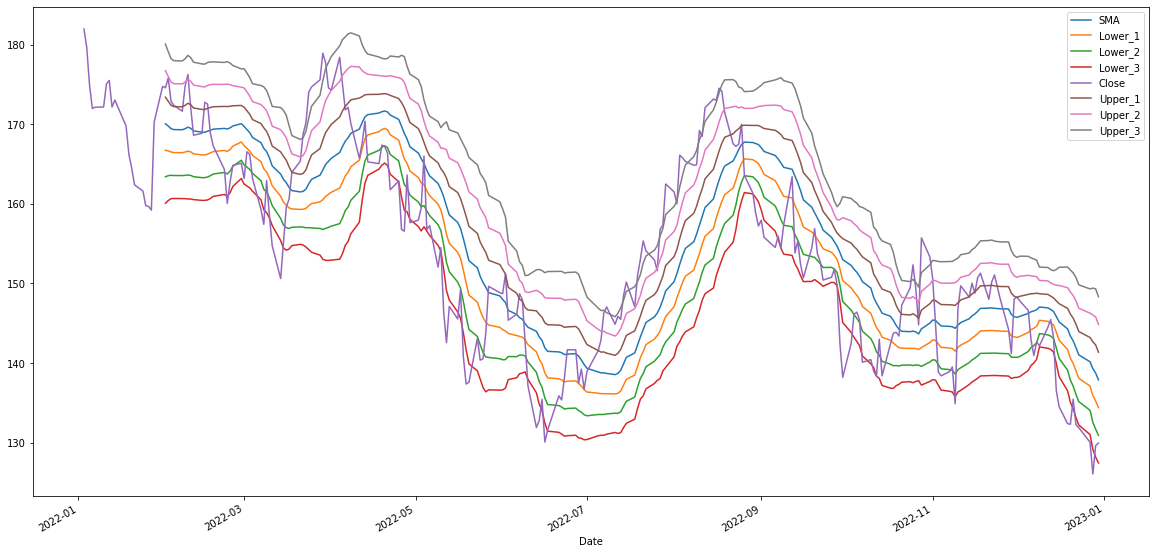

In [144]:
data[["SMA","Lower_1","Lower_2","Lower_3","Close","Upper_1","Upper_2","Upper_3"]].plot(figsize=(20,10))